In [10]:
# import matplotlib as mpl
# # Use the pgf backend (must be set before pyplot imported)
# mpl.use('pgf')

from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binomtest, sem, barnard_exact
import seaborn as sns
import pickle

mean = np.mean
from functools import cache
from sklearn.metrics import roc_curve, roc_auc_score

algorithms = ['detectron_dis', 'detectron_entropy', 'ensemble', 'ensemble_entropy', 'bbsd', 'bbsd_max_softmax',
              'bbsd_max_logit', 'bbsd_entropy']
from scipy.interpolate import interp1d

In [5]:
@cache
def get_exp(samples, shift, dataset='cifar'):
    r = []
    for file in glob(
            f'/voyager/projects/tomginsberg/detectron/checkpoints/{dataset}/detectron/*samples={samples}_shift={shift}.csv')[:10]:
        r.append(pd.read_csv(file).iloc[-1:])
    return pd.concat(r).reset_index(drop=True)

In [6]:
def pvals(tru, fls, n):
    x = []
    for t in tru:
        for f in fls:
            x.append(barnard(round(f * n), round(t * n), n))
    td = np.array(x)

    x = []

    for i, _ in enumerate(fls):
        for j, _ in enumerate(fls):
            if i == j:
                continue
            x.append(barnard(round(fls[i] * n), round(fls[j] * n), n))
    fd = np.array(x)
    return td, fd

In [7]:
def get_baseline(df, n):
    baseline = df.query(f'test_samples == {n}').query('shift==False').test_reject.mean()
    return baseline


def barnard(rp, rq, n):
    return barnard_exact([[rq, rp], [n - rq, n - rp]], alternative='greater').pvalue


def load_preds(seed, samples, shift):
    f = f'../checkpoints/uci/detectron/preds_{seed=}_{samples=}_{shift=}.pkl'
    return pickle.load(open(f, 'rb'))

In [8]:
from shift_detection.shiftdetection import ensemble_entropy
from scipy.stats import ks_2samp


def entropy_pvals(samples, hypothesis=True):
    pvals = []
    for i in range(100):
        for j in range(100):
            if hypothesis == False and i == j:
                continue
            pval = ks_2samp(ensemble_entropy(np.stack(load_preds(i, samples, hypothesis))),
                            ensemble_entropy(np.stack(load_preds(j, samples, False)))).pvalue
            pvals.append(pval)
    return np.array(pvals)


@cache
def detectron_pval(samples, dataset='cifar', method='dis'):
    if method == 'dis':
        fls = list(get_exp(samples, False, dataset).test_reject)
        tru = list(get_exp(samples, True, dataset).test_reject)
        s, n = pvals(tru, fls, samples)
    elif method == 'entropy':
        s = entropy_pvals(samples, True)
        n = entropy_pvals(samples, False)
    else:
        raise ValueError('method must be dis or entropy not {}'.format(method))
    return s, n


def query_pvals(algo, samples, dataset='cifar'):
    global em
    if 'detectron' in algo:
        return detectron_pval(samples, dataset, algo.split('_')[-1])
    df = em.query(f'algorithm=="{algo}" and test_samples=={samples}')
    s = np.array(df.query('shift==True').pvals)
    n = np.array(df.query('shift==False').pvals)
    if algo == 'bbsd':
        s = np.array([min(x) for x in s])
        n = np.array([min(x) for x in n])
    return s, n

In [11]:
st = ''
dataset = 'uci'
em = pd.read_json(f'../tables/{dataset}/shift.json')
for algorithm in algorithms:
    print(algorithm)
    for samples in [10, 20, 50]:
        s, n = query_pvals(algorithm, samples, dataset=dataset)
        fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
                                  y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
        # bound the type II error to be less than 5%
        # idx = np.where(fpr <= 0.05)[0][-1]
        # alpha = 1 - thr[idx]
        # td = s < alpha
        # td = 100 * mean(td), 100 * sem(td)
        # fd = n < alpha
        # fd = 100 * mean(fd), 100 * sem(fd)
        func = interp1d(fpr, tpr)
        td = func(0.05)
        td = 100 * td, 100 * (func(0.055) - func(0.045))
        fd = 0.05
        fd = 100 * fd, 0.5
        # st += f'n={samples}: td={td[0]:.2f} +- {td[1]:.2f} fd={fd[0]:.2f} +- {fd[1]:.2f} '
        # f'auc={np.trapz(tpr, fpr):.3f} alpha={thr[idx]}\n'

        print(f'${td[0]:.2f} \pm {td[1]:.2f}$ &  ${np.trapz(tpr, fpr):.3f}$', end=' & ')
    print('\n')

detectron_dis
$57.50 \pm 0.90$ &  $0.862$ & $48.25 \pm 0.45$ &  $0.824$ & $83.00 \pm 0.00$ &  $0.955$ & 

detectron_entropy


AttributeError: 'numpy.ndarray' object has no attribute 'softmax'

In [22]:
format_label = {'detectron': '\\textbf{Detectron (Ours)}',
                'ensemble_entropy': 'Ensemble (Entropy)',
                'bbsd_max_softmax': 'BBSD (Max Softmax)',
                'bbsd': 'BBSD (Bonferroni)',
                'bbsd_max_logit': 'BBSD (Max Logit)',
                'bbsd_entropy': 'BBSD (Entropy)',
                'ensemble': 'Ensemble (dis)'}

algo='detectron' samples=10 td=22.22+-0.02 auc=0.698
algo='ensemble' samples=10 td=1.65+-0.00 auc=0.474
algo='ensemble_entropy' samples=10 td=13.50+-0.01 auc=0.626
algo='bbsd' samples=10 td=13.36+-0.02 auc=0.607
algo='bbsd_max_softmax' samples=10 td=14.80+-0.04 auc=0.619
algo='detectron' samples=20 td=22.38+-0.00 auc=0.760
algo='ensemble' samples=20 td=0.26+-0.00 auc=0.542
algo='ensemble_entropy' samples=20 td=31.60+-0.04 auc=0.734
algo='bbsd' samples=20 td=22.32+-0.02 auc=0.665
algo='bbsd_max_softmax' samples=20 td=25.40+-0.03 auc=0.728
algo='detectron' samples=50 td=71.50+-0.03 auc=0.930
algo='ensemble' samples=50 td=32.13+-0.00 auc=0.674
algo='ensemble_entropy' samples=50 td=64.38+-0.04 auc=0.909
algo='bbsd' samples=50 td=45.10+-0.03 auc=0.828
algo='bbsd_max_softmax' samples=50 td=66.53+-0.02 auc=0.905


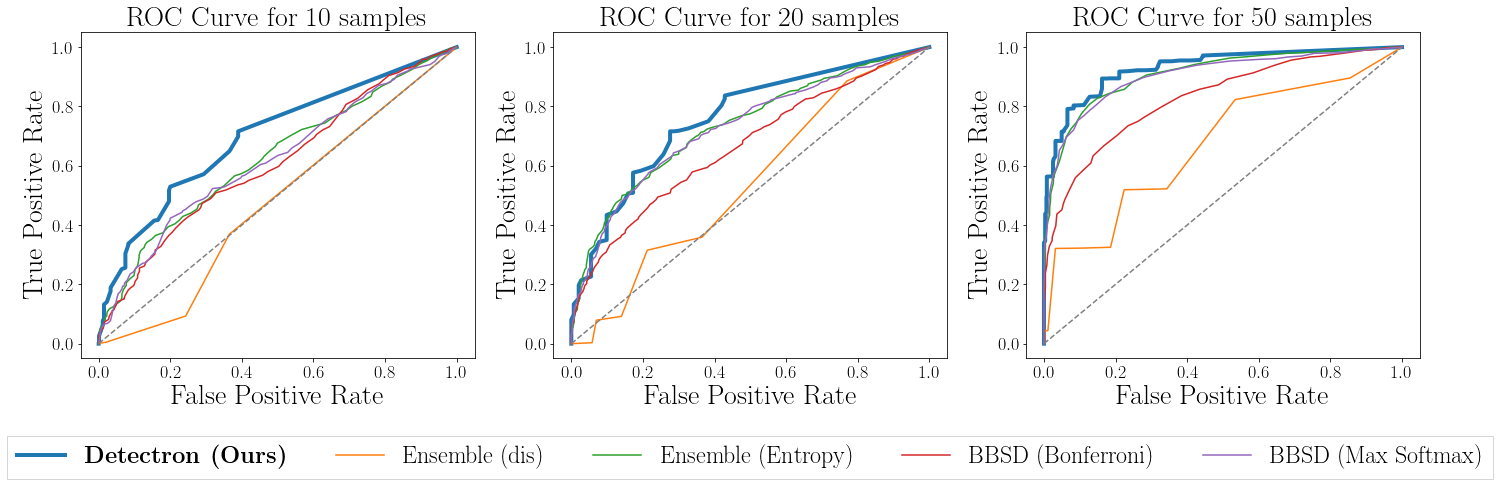

In [44]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
    'font.size': 18}
)
dataset = 'uci'
em = pd.read_json(f'../tables/{dataset}/shift.json')
d = {}
fig, axes = plt.subplots(1, 3, figsize=(24, 6), squeeze=False)
for samples, ax in zip([10, 20, 50], axes.ravel()):

    for algo in ['detectron', 'ensemble', 'ensemble_entropy', 'bbsd',
                 'bbsd_max_softmax']:  #, 'bbsd_max_logit', 'bbsd_entropy']:
        try:
            s, n = query_pvals(algo, samples, dataset=dataset)
        except ValueError:
            continue

        fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
                                  y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
        auc = roc_auc_score(y_score=(1 - np.concatenate([s, n])),
                            y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
        label = format_label[algo]
        if algo != 'detectron':
            ax.plot(fpr, tpr, label=label if samples == 20 else None)
        else:
            # make it thicker
            ax.plot(fpr, tpr, label=label if samples == 20 else None, linewidth=4)
        func = interp1d(fpr, tpr)
        td = func(0.05)
        td = td, (func(0.055) - func(0.045))

        if algo in d:
            d[algo][0].append(td[0].item())
            d[algo][1].append(auc)
        else:
            d[algo] = ([td[0].item()], [auc])
        print(f'{algo=} {samples=} td={100 * td[0]:.2f}+-{td[1]:.2f} auc={auc:.3f}')
        # ax.plot(fd, td, 'o', color='black')

    ax.set_xlabel('False Positive Rate', fontdict={'fontsize': 28})
    ax.set_ylabel('True Positive Rate', fontdict={'fontsize': 28})
    if samples == 20:
        ax.legend(fontsize=24, loc='upper center',
                  bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=5)
    ax.set_title(f'ROC Curve for {samples} samples', fontdict={'fontsize': 28})
    ax.plot([0, 1], [0, 1], '--', color='gray')

plt.show()
# fig.tight_layout()
# fig.savefig(f'/voyager/projects/tomginsberg/roc_curves_{dataset=}.pgf', bbox_inches='tight', format='pgf')

In [45]:
d

{'detectron': ([0.22216666666666668, 0.22375, 0.7150333333333333],
  [0.6981103448275863, 0.7604670498084292, 0.9301942528735633]),
 'ensemble': ([0.016495495495495494,
   0.002563636363636364,
   0.32126470588235295],
  [0.473773, 0.541775, 0.6737135]),
 'ensemble_entropy': ([0.135, 0.316, 0.64375],
  [0.6259379999999999, 0.733917, 0.9094355]),
 'bbsd': ([0.1336, 0.2232, 0.451],
  [0.607366, 0.6646409999999999, 0.8283820000000001]),
 'bbsd_max_softmax': ([0.14800000000000002, 0.254, 0.6653],
  [0.6189874999999999, 0.7276409999999999, 0.9047045])}

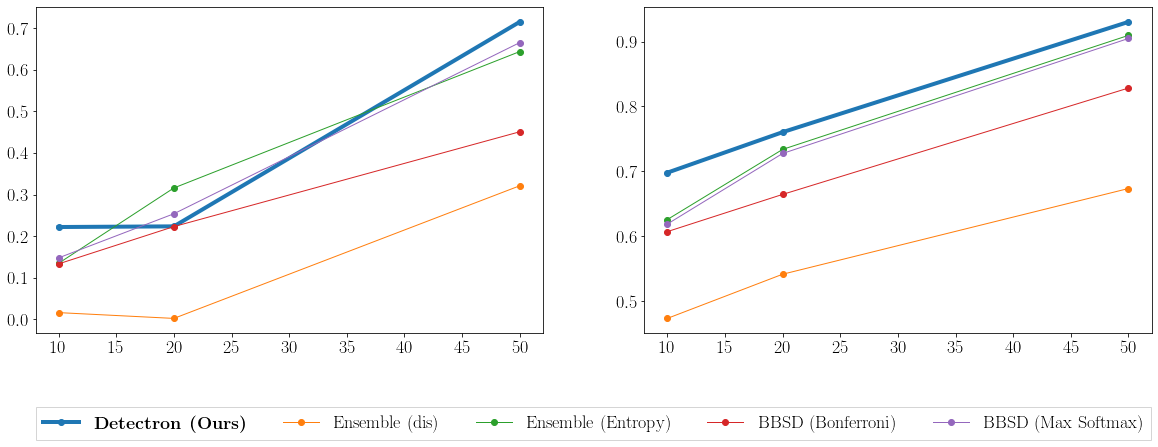

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6), squeeze=False)
for algo in d:
    if algo == 'detectron':
        linewidth = 4
    else:
        linewidth = 1
    axes[0][0].plot([10, 20, 50], d[algo][0], '-o', label=format_label[algo], linewidth=linewidth)
    axes[0][1].plot([10, 20, 50], d[algo][1], '-o', linewidth=linewidth, label=None)

axes[0][0].legend(loc='upper center',
                  bbox_to_anchor=(1.1, -0.2),
                  fancybox=False, shadow=False, ncol=5)

In [7]:
from data.cifar10 import CIFAR10DataModule
from models import pretrained
from shift_detection.shiftdetection import ShiftDetection, entropy, ensemble_entropy

dm = CIFAR10DataModule(test_samples='all', batch_size=1024, shift=True, negative_labels=False)

models, names = pretrained.all_camelyon_model(return_names=True, device='cuda:2', eval_=True)
em = ShiftDetection(models=models, model_names=names, datamodule=dm, df_path='../tables/camelyon',
                    logit_path='../logits/camelyon', load_logits=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.98it/s]


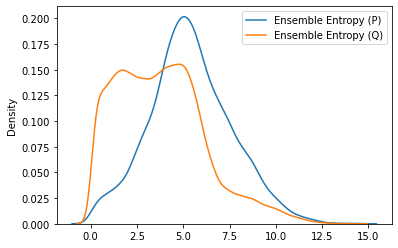

In [13]:
sns.kdeplot(em.p_data[0][0].max(1).values, label='Ensemble Entropy (P)')
sns.kdeplot((em.q_data[0][0]).max(1).values, label='Ensemble Entropy (Q)')
plt.legend()